In [2]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from helper import *
import math


from scipy.ndimage import binary_dilation, binary_erosion


In [3]:
def find_dominant(arr):
    # Get unique colors and their counts
    unique, counts = np.unique(arr, axis=0, return_counts=True)

    # Sort the counts in descending order
    sorted_counts_indices = np.argsort(-counts)

    # Get the color with the highest count as the dominant color
    dominant_color = unique[sorted_counts_indices[0]]

    return dominant_color


In [4]:
def calculate_distance(rgba1, rgba2):
    return np.sqrt(np.sum((rgba1 - rgba2) ** 2))

In [5]:
rgba1 = np.array([174,134,93,255], dtype=np.uint8)  # red
rgba2 = np.array([228, 195, 142, 255], dtype=np.uint8)  # green

distance = calculate_distance(rgba1, rgba2)

print(distance)  

18.275666882497067


In [6]:
def find_closest_color_mode1(arr, target_color):
    print("find_closest_color_mode1")
    arr = np.array(arr)
    arr = arr.astype(int)

    print(arr)
    print(target_color)

    distances = np.sqrt(np.sum((arr - target_color)**2, axis=1))
    closest_index = np.argmin(distances)

    print(distances)
    print("result ", closest_index)

    return closest_index


In [7]:
def find_closest_color(arr, compare_rgba):
    
    arr = np.array(arr)
    arr = arr.astype(int)

    # print("find_closest_color")
    # print(arr)
    # print(compare_rgba)
    # Find the index of the closest color
    distances = np.linalg.norm(arr - compare_rgba, axis=1)
    closest_index = np.argmin(distances)

    # print(distances)
    # print("result ",closest_index)
    return closest_index


In [8]:
k = np.array([
    np.array([48,  38,  34, 255], dtype=np.uint8),
    np.array([228, 195, 142, 255], dtype=np.uint8)
])

i = find_closest_color_mode1(k, np.array([174,134,93,255]))

print(i)


find_closest_color_mode1
[[ 48  38  34 255]
 [228 195 142 255]]
[174 134  93 255]
[169.03549923  95.06839643]
result  1
1


In [9]:
def calculate_darkness(rgba):
    return 1.0 - ((0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]) / 255.0)


In [10]:
def find_closest_color_darkness(rgba_array,target_rgba):
    darkness_array = np.array([calculate_darkness(rgba) for rgba in rgba_array])

    # Calculate the darkness of the target RGBA value
    target_darkness = calculate_darkness(target_rgba)

    # Find the index of the closest RGBA value based on darkness
    closest_index = np.argmin(np.abs(darkness_array - target_darkness))
    
    return closest_index


In [11]:
def get_edge_mask(mask):
    # Dilate the mask to get the boundary pixels
    dilated_mask = binary_dilation(mask)
    # Erode the mask to get the interior pixels
    eroded_mask = binary_erosion(mask)
    # Subtract the eroded mask from the dilated mask to get the boundary pixels
    edge_mask = np.logical_and(dilated_mask, np.logical_not(eroded_mask))
    return edge_mask


In [68]:
def edges_repair(rgba_image, class_img, binary_mask, sample=10):
    height = rgba_image.shape[0]
    width = rgba_image.shape[1]

    # class_img
    # rgba_image
    arr = []
    x_floor = math.floor(sample/2)
    left = x_floor
    right = sample-x_floor
    index = 0

    change_color = []

    class_img_out = class_img.copy()

    class_arr = class_img

    unique_class_arr = np.unique(class_arr)
    if (len(unique_class_arr) > 0):
        # print(unique_class_arr)
        cropped_image_filter = rgba_image

        # find dominant color in that class
        arr_dominant = []
        for u in unique_class_arr:
            arr_color = cropped_image_filter[class_arr == u]
            dom = find_dominant(arr_color)
            arr_dominant.append(dom)

        # print(arr_dominant)
        # print(unique_class_arr)
        class_arr_out = class_arr.copy()

        # Iterate over filter
        for y_filter in range(1, cropped_image_filter.shape[0]-1):
            for x_filter in range(1, cropped_image_filter.shape[1]-1):

                current_class = class_arr[y_filter][x_filter]

                can = False
                counter=0
                # Only change is its in the edge
                if (y_filter > 0 and x_filter > 0):
                    top = class_arr[y_filter-1][x_filter]
                    left = class_arr[y_filter][x_filter-1]
                    right = class_arr[y_filter][x_filter+1]
                    bottom = class_arr[y_filter+1][x_filter]

                    if(current_class == top):
                        counter+=1

                    if(current_class == left):
                        counter+=1

                    if(current_class == right):
                        counter+=1
                    
                    if(current_class == bottom):
                        counter+=1

                    if (counter<3):
                        can = True

                if(can):
                    compare_rgba = cropped_image_filter[y_filter][x_filter]
                    idx = find_closest_color(
                        arr_dominant, compare_rgba)

                    must_class = unique_class_arr[idx]
                    # print("compare_rgba ",compare_rgba, arr_dominant[idx])

                    if (current_class != must_class):
                        # change class
                        # if(current_class==4.0):
                        # print("compare_rgba ", compare_rgba)
                        # print("arr_dominant")
                        # print("idx ",idx)
                        # print("change color ", compare_rgba,arr_dominant[idx])
                        # print("change class ", current_class, must_class)
                        class_arr_out[y_filter][x_filter] = must_class

                        change_color.append(
                            [y_filter, x_filter, current_class, must_class])
                        class_img_out[y_filter][x_filter] = must_class
                        
        index += 1
        arr.append(
            [cropped_image_filter, class_arr, class_arr_out])

    return [arr, class_img_out]


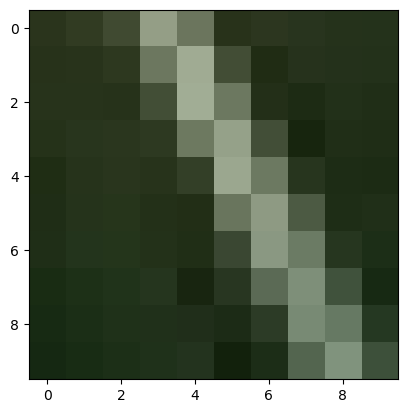

In [71]:
image = Image.open("images/parts/32_a.png")
image = np.asarray(image)
plt.imshow(image)

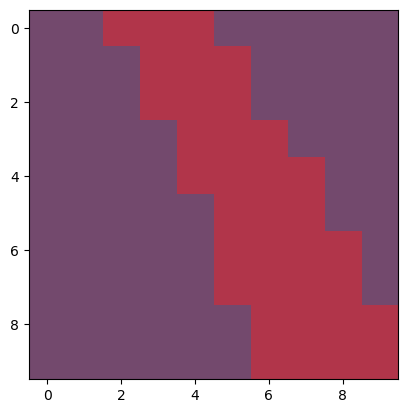

In [73]:
a = Image.open("images/parts/32_b.png")

a = np.asarray(a)

plt.imshow(a)

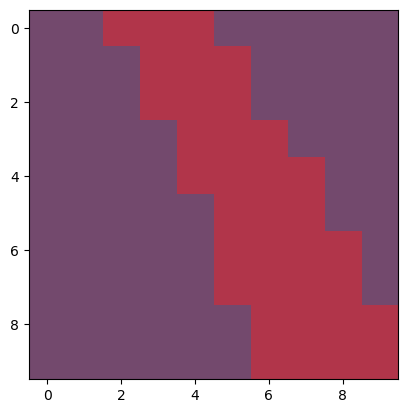

In [74]:
# print(a)

class_img = np.zeros((a.shape[0], a.shape[1]))


mask = np.all(a == a[0][0], axis=2)

edge = get_edge_mask(mask)
plt.imshow(a)

# plt.imshow(mask)

class_img[mask] = 1
# class_img[a[:, :, :3] == [179, 154, 217, 255]] = 1

# [179, 154, 217, 255]
# [176, 80, 147, 255]

# plt.imshow(class_img)s

# print(class_img)


In [75]:
arr, class_img_out = edges_repair(image, class_img,edge, 10)


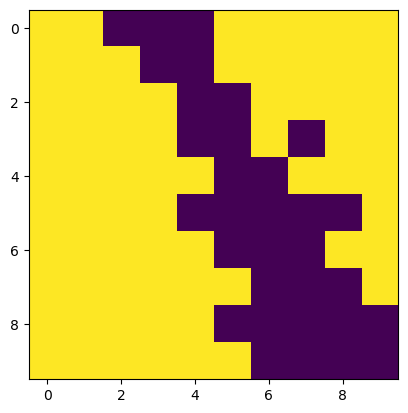

In [76]:
plt.imshow(class_img_out)

In [65]:
height = class_img.shape[0]
width = class_img.shape[1]


class_img_a = class_img.copy()

for y_filter in range(1, class_img.shape[0]-1):
    for x_filter in range(1, class_img.shape[1]-1):
        current_class = class_img[y_filter][x_filter]

        can = False
        counter= 0
        # Only change is its in the edge
        if (y_filter > 0 and x_filter > 0):
            top = class_img[y_filter-1][x_filter]
            left = class_img[y_filter][x_filter-1]
            right = class_img[y_filter][x_filter+1]
            bottom = class_img[y_filter+1][x_filter]

            if(current_class == top):
                counter+=1

            if(current_class == left):
                counter+=1

            if(current_class == right):
                counter+=1
            
            if(current_class == bottom):
                counter+=1

            if (counter<3):
                can = True

        if (can):
            class_img_a[y_filter][x_filter] = 9


In [61]:
print(class_img)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 1. 1.]]


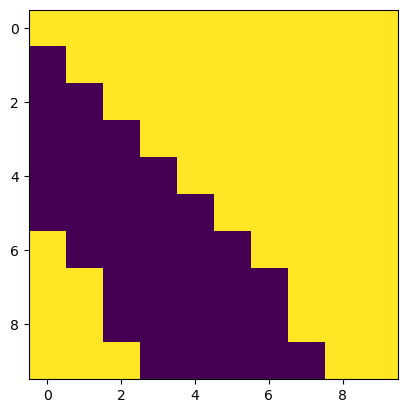

In [62]:
plt.imshow(class_img)

In [66]:
print(class_img_a)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 9. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 9. 9. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 9. 9. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 9. 9. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 9. 9. 1. 1. 1. 1.]
 [1. 9. 0. 0. 0. 9. 9. 1. 1. 1.]
 [1. 9. 0. 0. 0. 0. 9. 1. 1. 1.]
 [1. 1. 9. 0. 0. 0. 0. 9. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 1. 1.]]


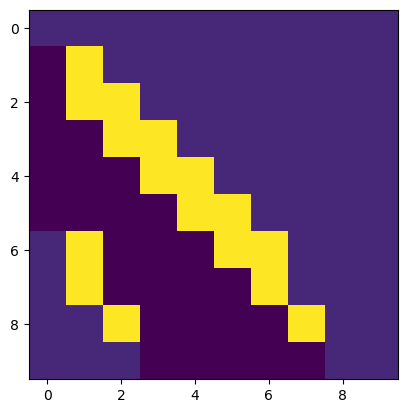

In [67]:
plt.imshow(class_img_a)

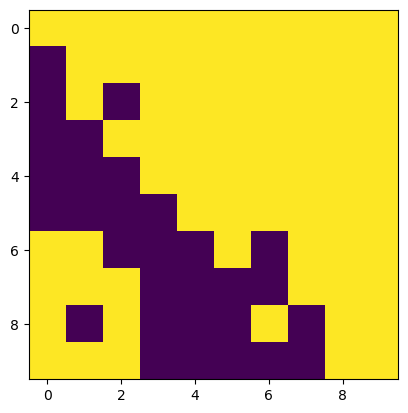

In [52]:
plt.imshow(class_img_out)

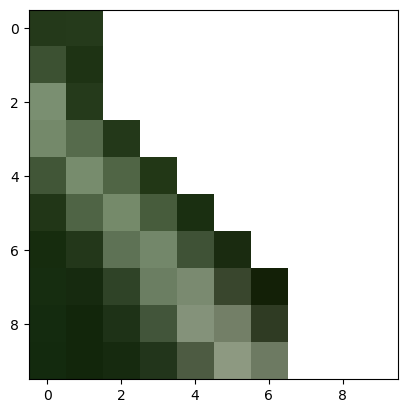

In [64]:
# Make canny edge from whole imagge
edges = canny_edge_detection(image)
kernel = np.ones((5, 5), np.uint8)
closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
rgba_img_canny = image.copy()
rgba_img_canny[closed_edges == 0] = [0, 0, 0, 0]

plt.imshow(rgba_img_canny)


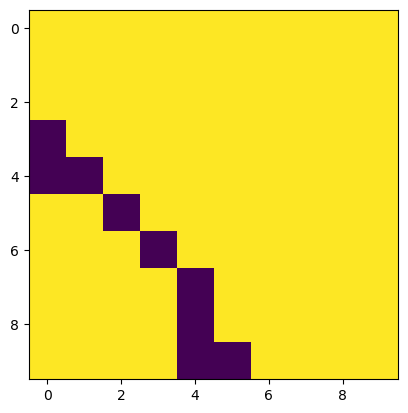

In [55]:
from scipy.ndimage import binary_dilation

# create a 10x10 binary image
# img = np.zeros((10, 10), dtype=bool)
# img[3:7, 3:7] = True

# define the structuring element for dilation
struct = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]])

# perform dilation on the true region of the image
# dilated_img = np.zeros((10, 10), dtype=bool)
dilated_img = binary_dilation(class_img_out, struct)

plt.imshow(dilated_img)


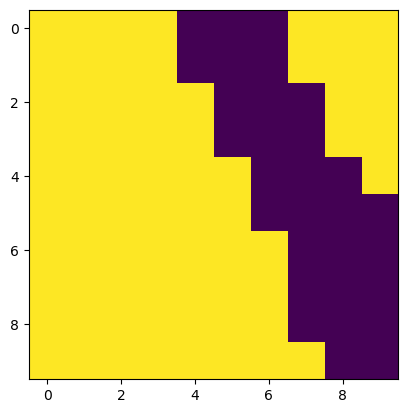

In [44]:
plt.imshow(class_img)

[[[176  80 147 255]
  [176  80 147 255]
  [176  80 147 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]]

 [[176  80 147 255]
  [176  80 147 255]
  [176  80 147 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]]

 [[176  80 147 255]
  [176  80 147 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [176  80 147 255]
  [179 154 217 255]
  [176  80 147 255]]

 [[176  80 147 255]
  [176  80 147 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]]

 [[176  80 147 255]
  [176  80 147 255]
  [176  80 147 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [179 154 217 255]
  [176  80 1

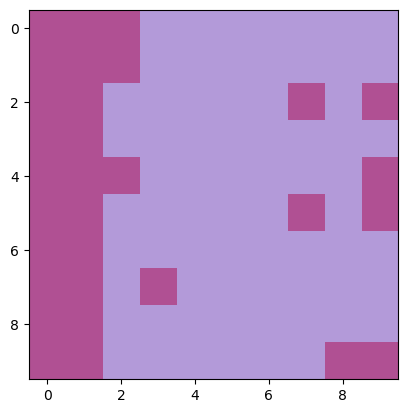

In [21]:
c = Image.open("images/parts/1_c.png")

c = np.asarray(c)

plt.imshow(c)
print(c)